In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Random Forest Method

#### Gini Impurity Calculation
Gini impurity measures how mixed the classes are within a node. It is computed as:

$$
\text{Gini impurity}(S) = 1 - \sum_{i=1}^{k} p_i^2
$$

Where:

- $S$ = collection of features
- $p_i$ = proportion of samples belonging to class \( i \)  
- $k$ = total number of classes  

A Gini value of 0 indicates a perfectly pure node (all samples belong to one class), while higher values indicate more class mixing.

#### Information Gain (Split Criterion)

Decision trees choose the split that produces the largest reduction in impurity.  
Information gain is defined as:

$$
\text{Gain}(S, A) = \text{Impurity}(S) - \sum_{v\in Value(A)} 
\frac{|S_v|}{|S|} \text{Impurity}(S_v)
$$

Where:

- $S$ is a collection of features
- $A$ is a feature in $S$
- Value(A) is the set of all possible values for attribute A
- $S_v$ is the subset of $S$ for which attribute A has value $v$. 

The split with the highest information gain is selected.

### Baseline Random Forest Model
This is run on the cleaned/normalized data as well as sklearn default parameters. This gives us an idea of how this model may perform and potential hyperparameters to focus on during fine-tuning.

In [13]:
# import data
df_train = pd.read_csv("../../data/processed/winequality-red-normalized-train.csv")
df_test = pd.read_csv("../../data/processed/winequality-red-normalized-test.csv")

X_train = df_train.drop(columns=["quality"])
y_train = df_train["quality"]
X_test = df_test.drop(columns=["quality"])
y_test = df_test["quality"]

In [14]:
from sklearn.ensemble import RandomForestClassifier

# fit baseline random forest
rf_baseline = RandomForestClassifier(random_state=42)

rf_baseline.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
from sklearn.metrics import accuracy_score, f1_score

y_pred = rf_baseline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.6875
F1 Score: 0.4056396716777125


In [16]:
from sklearn.metrics import classification_report

report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()
df_report

,precision,recall,f1-score,support
3,0.000000,0.000000,0.000000,2.0000
4,0.000000,0.000000,0.000000,11.0000
5,0.730496,0.757353,0.743682,136.0000
6,0.644295,0.750000,0.693141,128.0000
7,0.740741,0.500000,0.597015,40.0000
8,0.500000,0.333333,0.400000,3.0000
accuracy,0.687500,0.687500,0.687500,0.6875
macro avg,0.435922,0.390114,0.405640,320.0000
weighted avg,0.665459,0.687500,0.671698,320.0000


The random forest baseline model performs well on the most common wine qualities (5 and 6), achieving F1 scores of above 0.69, meaning that it's doing a pretty good job at correctly identifying the class while balancing false positives and false negatives. It struggles more with the minority classes (3, 4, and 8), and the macro F1 score is 0.406 due to the class imbalance present. The overall accuracy of 68.8% is pretty strong as a baseline for this dataset, but further fine-tuning is needed to improve performance further.

### Improving the baseline model
Next, we will perform Grid Search Cross Validation on each of the three datasets (our original, PCA, and interaction term).

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [24]:
datasets = {
    "normalized": {
        "train": pd.read_csv("../../data/processed/winequality-red-normalized-train.csv"),
        "test": pd.read_csv("../../data/processed/winequality-red-normalized-test.csv")
    },
    "pca": {
        "train": pd.read_csv("../../data/processed/winequality-red-pca-train.csv"),
        "test": pd.read_csv("../../data/processed/winequality-red-pca-test.csv")
    },
    "smote": {
        "train": pd.read_csv("../../data/processed/winequality-red-oversampling-train.csv"),
        "test": pd.read_csv("../../data/processed/winequality-red-normalized-test.csv")  # correct pairing?
    }
}

In [25]:
param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [None, 15, 25, 50],
    "max_features": ['sqrt', 'log2', None],
    "class_weight": [None, "balanced"]
}


normalized dataset
Best parameters: {'class_weight': None, 'max_depth': None, 'max_features': None, 'n_estimators': 50}
CV Macro F1 (mean): 0.3614
CV Macro F1 (std):  0.0341
Test Macro F1: 0.3971

Test Accuracy: 0.6781
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.72      0.77      0.75       136
           6       0.64      0.72      0.68       128
           7       0.68      0.47      0.56        40
           8       0.50      0.33      0.40         3

    accuracy                           0.68       320
   macro avg       0.42      0.38      0.40       320
weighted avg       0.65      0.68      0.66       320



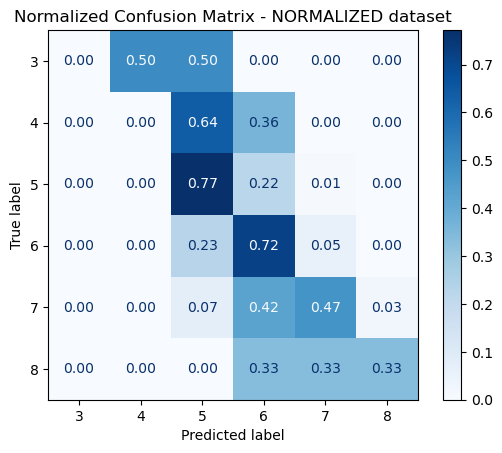


pca dataset
Best parameters: {'class_weight': None, 'max_depth': 15, 'max_features': None, 'n_estimators': 200}
CV Macro F1 (mean): 0.3647
CV Macro F1 (std):  0.0745
Test Macro F1: 0.3914

Test Accuracy: 0.6687
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.70      0.78      0.74       136
           6       0.64      0.70      0.66       128
           7       0.69      0.45      0.55        40
           8       0.50      0.33      0.40         3

    accuracy                           0.67       320
   macro avg       0.42      0.38      0.39       320
weighted avg       0.64      0.67      0.65       320



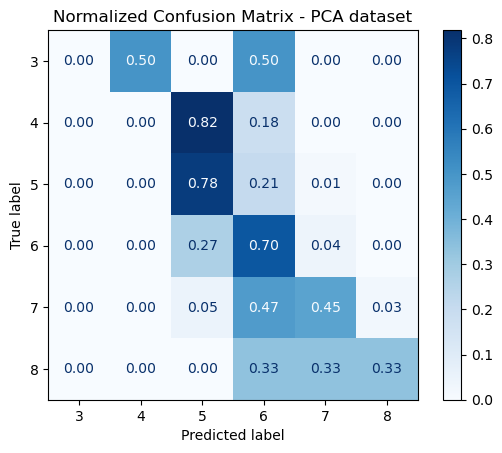


smote dataset
Best parameters: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
CV Macro F1 (mean): 0.8709
CV Macro F1 (std):  0.0070
Test Macro F1: 0.4029

Test Accuracy: 0.6531
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.14      0.18      0.16        11
           5       0.75      0.74      0.75       136
           6       0.66      0.63      0.65       128
           7       0.56      0.60      0.58        40
           8       0.25      0.33      0.29         3

    accuracy                           0.65       320
   macro avg       0.39      0.42      0.40       320
weighted avg       0.66      0.65      0.66       320



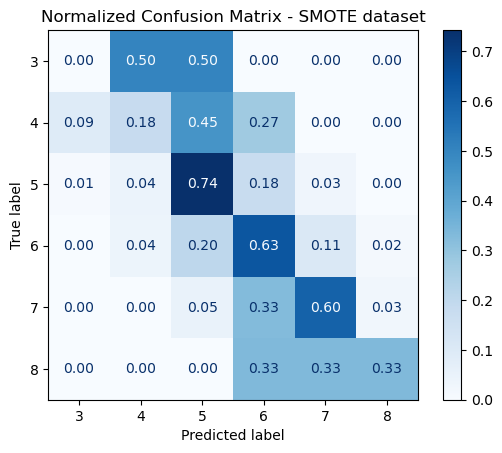

In [29]:
results_table = []

for name, dset in datasets.items():
    print(f"\n{name} dataset")

    train_df = dset["train"]
    test_df = dset["test"]

    # split into X and y
    X_train = train_df.drop(columns=["quality"])
    y_train = train_df["quality"]
    X_test = test_df.drop(columns=["quality"])
    y_test = test_df["quality"]

    # grid search
    grid = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        scoring="f1_macro",
        cv=5,
        n_jobs=-1,
        return_train_score=True
    )

    grid.fit(X_train, y_train)

    best_idx = grid.best_index_
    best_params = grid.best_params_

    # CV metrics
    train_cv_macro_f1_mean = grid.cv_results_["mean_train_score"][best_idx]
    train_cv_macro_f1_std  = grid.cv_results_["std_train_score"][best_idx]
    val_cv_macro_f1_mean   = grid.best_score_
    val_cv_macro_f1_std    = grid.cv_results_["std_test_score"][best_idx]

    print("Best parameters:", best_params)
    print(f"CV Macro F1 (mean): {val_cv_macro_f1_mean:.4f}")
    print(f"CV Macro F1 (std):  {val_cv_macro_f1_std:.4f}")

    # train model on full training data
    best_model = RandomForestClassifier(**best_params, random_state=42)
    best_model.fit(X_train, y_train)

    # predict on test set
    y_pred = best_model.predict(X_test)

    # test metrics
    test_macro_f1 = f1_score(y_test, y_pred, average="macro")
    test_acc = accuracy_score(y_test, y_pred)

    print(f"Test Macro F1: {test_macro_f1:.4f}\n")
    print(f"Test Accuracy: {test_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_train.unique()))
    disp.plot(cmap="Blues", values_format=".2f")
    plt.title(f"Normalized Confusion Matrix - {name.upper()} dataset")
    plt.show()

    # store results
    results_table.append({
        "Dataset": name,
        "Train CV Macro F1 (mean)": round(train_cv_macro_f1_mean, 4),
        "Train CV Macro F1 (std)": round(train_cv_macro_f1_std, 4),
        "Test Macro F1": round(test_macro_f1, 4),
        "Val CV Macro F1 (mean)": round(val_cv_macro_f1_mean, 4),
        "Val CV Macro F1 (std)": round(val_cv_macro_f1_std, 4),
        "Test Accuracy": round(test_acc, 4)
    })

results_df = pd.DataFrame(results_table)

In [10]:
results_df

,Dataset,CV Macro F1 (mean),CV Macro F1 (std),Test Accuracy,Test Macro F1
0,normalized,0.3523,0.0400,0.6906,0.4132
1,pca,0.3625,0.0693,0.6562,0.3880
2,interactions,0.3477,0.0491,0.6844,0.4018


### Effects of hyperparameter class_weight
Here, I will test the efficacy of the class_weight hyperparameter on model performance on the normalized dataset. 

In [11]:
X = df_norm.drop(columns=["quality"])
y = df_norm["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# best hyperparameters from GridSearch besides class_weight
best_params_fixed = {
    "n_estimators": 100,
    "max_depth": None,
    "max_features": None,
    "random_state": 42
}

results = {}

for cw in [None, "balanced"]:
    print(f"\nUsing class_weight = {cw}")
    
    model = RandomForestClassifier(class_weight=cw, **best_params_fixed)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {macro_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))


Using class_weight = None
Accuracy: 0.6719
Macro F1: 0.3888

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.71      0.76      0.73       136
           6       0.63      0.71      0.67       128
           7       0.74      0.50      0.60        40
           8       0.33      0.33      0.33         3

    accuracy                           0.67       320
   macro avg       0.40      0.38      0.39       320
weighted avg       0.65      0.67      0.66       320


Using class_weight = balanced
Accuracy: 0.6906
Macro F1: 0.4132

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.73      0.77      0.75       136
           6       0.65      0.72      0.68       128
           7

Without the class_weight parameter, the model achieves an accuracy of 0.67 and macro F1 of 0.389, indicating problems with performance in smaller classes. Introducing class weights improves macro F1 to 0.4132, indicating increase in performance on smaller classes (particularly quality = 8). This also did not sacrifice performance on the bigger classes, and improved accuracy overall. 

### NEW

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay,
    confusion_matrix,
)

from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [9]:
# load data
raw_path = "../../data/raw/winequality-red.csv"

with open(raw_path, "r") as f:
    header_line = f.readline().strip()

header_clean = header_line.replace('""', '"').replace('"', '')
columns = [col.strip() for col in header_clean.split(';')]

df_raw = pd.read_csv(raw_path, sep=";", skiprows=1, names=columns)

X = df_raw.drop(columns=["quality"])
y = df_raw["quality"]

# split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

Running normalized pipeline
Best parameters: {'rf__class_weight': 'balanced', 'rf__max_depth': 25, 'rf__max_features': None, 'rf__n_estimators': 100}
Train CV Macro F1 (mean): 1.0000
Train CV Macro F1 (std):  0.0000
Val   CV Macro F1 (mean): 0.3510
Val   CV Macro F1 (std):  0.0333

Test Macro F1: 0.4146
Test Accuracy: 0.6969

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.74      0.78      0.76       136
           6       0.65      0.73      0.69       128
           7       0.72      0.57      0.64        40
           8       0.50      0.33      0.40         3

    accuracy                           0.70       320
   macro avg       0.44      0.40      0.41       320
weighted avg       0.67      0.70      0.68       320



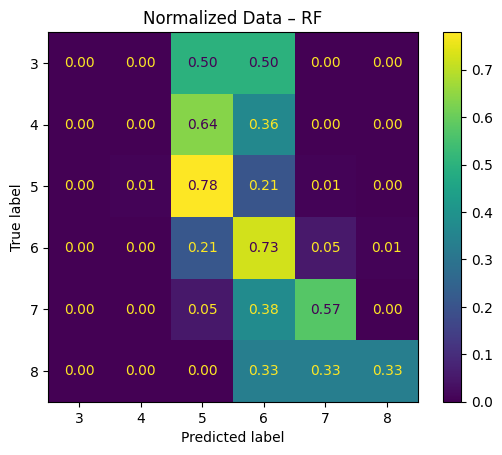

In [10]:
pipe_normalized = SkPipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=42)),
])

param_grid_normalized = {
    "rf__n_estimators": [50, 100, 150, 200],
    "rf__max_depth": [None, 15, 25, 50],
    "rf__max_features": ["sqrt", "log2", None],
    "rf__class_weight": [None, "balanced"],
}

grid_norm = GridSearchCV(
    pipe_normalized,
    param_grid=param_grid_normalized,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    return_train_score=True,
)

print("Running normalized pipeline")
grid_norm.fit(X_train, y_train)

best_idx = grid_norm.best_index_
best_params = grid_norm.best_params_

# cv metrics
train_cv_macro_f1_mean = grid_norm.cv_results_["mean_train_score"][best_idx]
train_cv_macro_f1_std  = grid_norm.cv_results_["std_train_score"][best_idx]

val_cv_macro_f1_mean = grid_norm.best_score_
val_cv_macro_f1_std  = grid_norm.cv_results_["std_test_score"][best_idx]

print("Best parameters:", best_params)
print(f"Train CV Macro F1 (mean): {train_cv_macro_f1_mean:.4f}")
print(f"Train CV Macro F1 (std):  {train_cv_macro_f1_std:.4f}")
print(f"Val   CV Macro F1 (mean): {val_cv_macro_f1_mean:.4f}")
print(f"Val   CV Macro F1 (std):  {val_cv_macro_f1_std:.4f}")

# test metrics
best_norm = grid_norm.best_estimator_
y_pred_norm = best_norm.predict(X_test)

test_macro_f1 = f1_score(y_test, y_pred_norm, average="macro")
test_acc = accuracy_score(y_test, y_pred_norm)

print(f"\nTest Macro F1: {test_macro_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_norm, zero_division=0))

# confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_norm, normalize="true", values_format=".2f"
)
plt.title("Normalized Data – RF")
plt.show()

Running PCA pipeline
Best parameters: {'rf__class_weight': None, 'rf__max_depth': 25, 'rf__max_features': 'sqrt', 'rf__n_estimators': 50}
Train CV Macro F1 (mean): 1.0000
Train CV Macro F1 (std):  0.0000
Val   CV Macro F1 (mean): 0.3734
Val   CV Macro F1 (std):  0.0685

Test Macro F1: 0.4106
Test Accuracy: 0.6531

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       1.00      0.09      0.17        11
           5       0.72      0.75      0.74       136
           6       0.61      0.66      0.63       128
           7       0.56      0.50      0.53        40
           8       0.50      0.33      0.40         3

    accuracy                           0.65       320
   macro avg       0.56      0.39      0.41       320
weighted avg       0.66      0.65      0.64       320



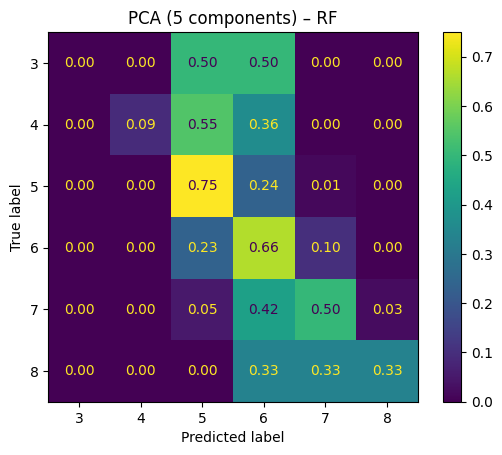

In [13]:
pipe_pca = SkPipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=5)),
    ("rf", RandomForestClassifier(random_state=42)),
])

param_grid_pca = {
    "rf__n_estimators": [50, 100, 150, 200],
    "rf__max_depth": [None, 15, 25, 50],
    "rf__max_features": ["sqrt", "log2", None],
    "rf__class_weight": [None, "balanced"],
}

grid_pca = GridSearchCV(
    pipe_pca,
    param_grid=param_grid_pca,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    return_train_score=True,
)

print("Running PCA pipeline")
grid_pca.fit(X_train, y_train)

best_idx = grid_pca.best_index_
best_params_pca = grid_pca.best_params_

# cv metrics
train_cv_macro_f1_mean = grid_pca.cv_results_["mean_train_score"][best_idx]
train_cv_macro_f1_std  = grid_pca.cv_results_["std_train_score"][best_idx]
val_cv_macro_f1_mean   = grid_pca.best_score_
val_cv_macro_f1_std    = grid_pca.cv_results_["std_test_score"][best_idx]

print("Best parameters:", best_params_pca)
print(f"Train CV Macro F1 (mean): {train_cv_macro_f1_mean:.4f}")
print(f"Train CV Macro F1 (std):  {train_cv_macro_f1_std:.4f}")
print(f"Val   CV Macro F1 (mean): {val_cv_macro_f1_mean:.4f}")
print(f"Val   CV Macro F1 (std):  {val_cv_macro_f1_std:.4f}")

# test metrics
best_pca = grid_pca.best_estimator_
y_pred_pca = best_pca.predict(X_test)

test_macro_f1_pca = f1_score(y_test, y_pred_pca, average="macro")
test_acc_pca = accuracy_score(y_test, y_pred_pca)

print(f"\nTest Macro F1: {test_macro_f1_pca:.4f}")
print(f"Test Accuracy: {test_acc_pca:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_pca, zero_division=0))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_pca, normalize="true", values_format=".2f"
)
plt.title("PCA (5 components) – RF")
plt.show()

Running SMOTE pipeline
Best parameters: {'rf__class_weight': None, 'rf__max_depth': 15, 'rf__max_features': 'sqrt', 'rf__n_estimators': 150}
Train CV Macro F1 (mean): 1.0000
Train CV Macro F1 (std):  0.0000
Val   CV Macro F1 (mean): 0.3802
Val   CV Macro F1 (std):  0.0453

Test Macro F1: 0.3867
Test Accuracy: 0.6438

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.12      0.18      0.15        11
           5       0.75      0.72      0.74       136
           6       0.65      0.62      0.63       128
           7       0.59      0.65      0.62        40
           8       0.12      0.33      0.18         3

    accuracy                           0.64       320
   macro avg       0.37      0.42      0.39       320
weighted avg       0.66      0.64      0.65       320



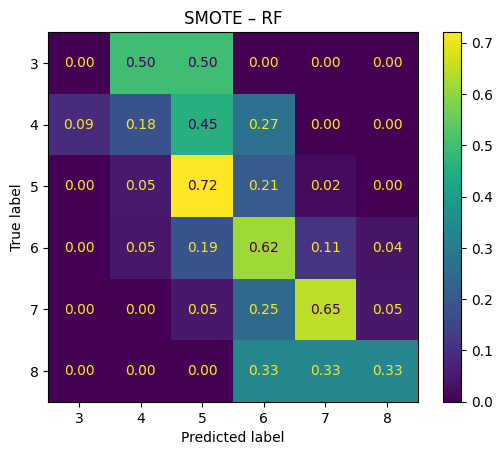

In [14]:
pipe_smote = ImbPipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42, k_neighbors=3)),
    ("rf", RandomForestClassifier(random_state=42)),
])

param_grid_smote = {
    "rf__n_estimators": [50, 100, 150, 200],
    "rf__max_depth": [None, 15, 25, 50],
    "rf__max_features": ["sqrt", "log2", None],
    "rf__class_weight": [None, "balanced"],
}

grid_smote = GridSearchCV(
    pipe_smote,
    param_grid=param_grid_smote,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    return_train_score=True,
)

print("Running SMOTE pipeline")
grid_smote.fit(X_train, y_train)

best_idx_smote = grid_smote.best_index_
best_params_smote = grid_smote.best_params_

# cv metrics
train_cv_macro_f1_mean_sm = grid_smote.cv_results_["mean_train_score"][best_idx_smote]
train_cv_macro_f1_std_sm  = grid_smote.cv_results_["std_train_score"][best_idx_smote]
val_cv_macro_f1_mean_sm   = grid_smote.best_score_
val_cv_macro_f1_std_sm    = grid_smote.cv_results_["std_test_score"][best_idx_smote]

print("Best parameters:", best_params_smote)
print(f"Train CV Macro F1 (mean): {train_cv_macro_f1_mean_sm:.4f}")
print(f"Train CV Macro F1 (std):  {train_cv_macro_f1_std_sm:.4f}")
print(f"Val   CV Macro F1 (mean): {val_cv_macro_f1_mean_sm:.4f}")
print(f"Val   CV Macro F1 (std):  {val_cv_macro_f1_std_sm:.4f}")

# test metrics
best_smote = grid_smote.best_estimator_
y_pred_smote = best_smote.predict(X_test)

test_macro_f1_smote = f1_score(y_test, y_pred_smote, average="macro")
test_acc_smote = accuracy_score(y_test, y_pred_smote)

print(f"\nTest Macro F1: {test_macro_f1_smote:.4f}")
print(f"Test Accuracy: {test_acc_smote:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote, zero_division=0))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_smote, normalize="true", values_format=".2f"
)
plt.title("SMOTE – RF")
plt.show()